## Курсовой проект для курса "Python для Data Science"

### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Рекомендации для файла с кодом (ipynb):

8. Допускается применение библиотек Python и моделей машинного обучения,которые были в данном курсе.

In [379]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import math
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [380]:
# TRAIN_DATASET_PATH = 'C:/Users/tazts/Documents/data/train.csv' # y_train, y_valid
# TEST_DATASET_PATH = 'C:/Users/tazts/Documents/data/test.csv'
TRAIN_DATASET_PATH = '../train.csv' # y_train, y_valid
TEST_DATASET_PATH = '../test.csv'

In [381]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
df.head(5) 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Описание датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видим пропуски в LifeSquare и Healthcare_1. Видим буквенные категории в Ecology_2, Ecology_3, Shops_2 - будем разбираться в следующем разделе.

### Предобработка данных
####  Преобразования категориальных переменных в числовые

##### Ecology_2, Ecology_2, Ecology_3, Shops_2 

In [383]:
df.Ecology_2.value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [384]:
print(df.loc[df['Ecology_2']=='B', 'Price'].mean())
print(df.loc[df['Ecology_2']=='A', 'Price'].mean())

214344.5442227426
193139.71700581786


<Axes: >

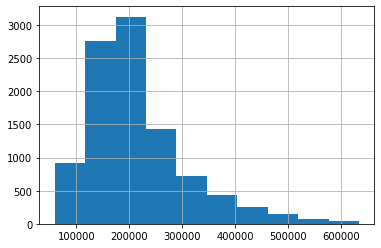

In [385]:
df.loc[df['Ecology_2']=='B', 'Price'].hist()

<Axes: >

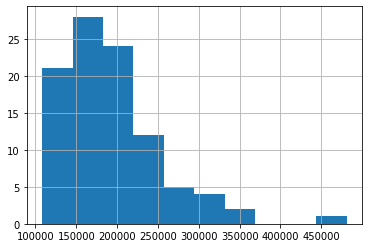

In [386]:
df.loc[df['Ecology_2']=='A', 'Price'].hist()

Редкий, но судя по всему, очень значительный признак. Применим к нему 

In [387]:
df.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [388]:
df.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [389]:
df = pd.get_dummies(df, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

### Числовые признаки
#### Id
Id не значимый признак, поэтому выбрасываем их. Но запишим их в свою таблицу для выходного файла.

In [390]:
df.drop('Id', axis=1, inplace=True)
test_id = test['Id']
test.drop('Id', axis=1, inplace=True)

#### Мультиколлинеарность 

In [391]:
cm = sns.light_palette("green", as_cmap=True)
s = pd.DataFrame(df.corr()).style.background_gradient(cmap=cm)
s

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B
DistrictId,1.000000,0.071432,-0.026613,-0.019910,0.040358,-0.120373,-0.149051,0.013430,0.065294,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100,-0.093406,-0.027902,-0.021018
Rooms,0.071432,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291,-0.001971,-0.005909,-0.000146
Square,-0.026613,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075,0.029926,0.022748,-0.049380
LifeSquare,-0.019910,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292,0.006808,0.008597,-0.004692
KitchenSquare,0.040358,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864,0.000268,-0.007919,-0.017315
Floor,-0.120373,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715,0.049661,0.025767,-0.013626
HouseFloor,-0.149051,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280,0.059347,0.009258,0.051002
HouseYear,0.013430,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305,0.000997,0.001686,0.002994
Ecology_1,0.065294,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381,-0.110725,-0.223197,0.079809
Social_1,0.246463,0.075980,-0.070690,-0.048363,0.043379,-0.044914,-0.020801,0.003026,0.026464,1.000000,0.955988,0.023721,0.077133,0.524593,0.526272,0.263286,-0.066017,-0.037777,0.144644


#### Social_1 и Social_2
Так как эти признаки между собой очень сильно коррелируют, то удалим Social_1 (так как имеет чуть более сильную корреляцию с другими признаками).

In [392]:
df.drop('Social_1', axis=1, inplace=True)
test.drop('Social_1', axis=1, inplace=True)

#### HouseYear

Посмотрим на разнообразие года постройки

In [393]:
df.HouseYear.value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
4968       1
1914       1
1916       1
1910       1
1928       1
Name: HouseYear, Length: 97, dtype: int64

In [394]:
df.loc[((df['HouseYear']>df['HouseYear'].quantile(.999))|(df['HouseYear']<df['HouseYear'].quantile(.001)))]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B
910,172,2.0,56.172364,28.384213,7.0,8,6.0,1914,0.000000,1660,39,1786.0,1,5,423580.477982,1,1,1
1380,195,3.0,75.564709,44.872616,9.0,5,7.0,1917,0.015017,3079,59,2890.0,0,8,486057.129888,1,1,1
1497,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,6141,10,262.0,3,6,254084.534396,1,1,1
2656,183,4.0,151.150660,98.187482,23.0,6,7.0,1912,0.037316,6748,93,562.0,4,10,284884.959104,1,1,1
4189,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,4756,16,2857.0,5,8,243028.603096,1,1,1
5053,104,1.0,35.507738,20.312725,4.0,6,5.0,1917,0.000078,6398,141,1046.0,3,23,236830.764637,1,1,1
5111,161,1.0,63.293079,29.389815,18.0,3,9.0,1912,0.014423,3806,4,NaN,0,3,262279.813915,1,1,1
7611,183,3.0,102.964468,48.322107,14.0,4,6.0,1916,0.037316,6748,93,562.0,4,10,284608.939261,1,1,1
8144,189,2.0,54.751367,31.515082,10.0,2,4.0,1917,0.000078,6398,141,1046.0,3,23,69623.753191,1,1,1
9317,161,1.0,50.808925,15.920343,20.0,8,9.0,1910,0.014423,3806,4,NaN,0,3,287954.720682,1,1,1


In [395]:
df.loc[df['HouseYear']==20052011, 'HouseYear'] = 2011
df['HouseYear'].quantile(.999)

2020.0

Видим, что абсолютное большинство датированно 2020 годом, все что младше заполню модой (кроме ошибочного значения 20052011 - его считаю ошибочным и присваиваю дату 2011 - считаю, что взяли годы постройки).

In [396]:
stats.mode(df['HouseYear'], keepdims=True)[0][0]

1977

<Axes: >

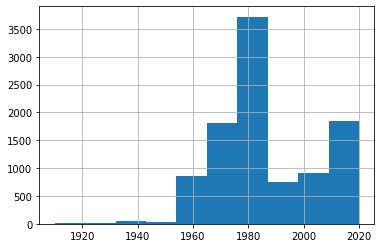

In [397]:
df.loc[df['HouseYear']>2020,'HouseYear'] = stats.mode(df['HouseYear'], keepdims=True)[0][0]
test.loc[test['HouseYear']>2020,'HouseYear'] = stats.mode(df['HouseYear'], keepdims=True)[0][0]
df['HouseYear'].hist()

#### Описание данных

In [398]:
df[['Rooms', 'Square', 'LifeSquare','KitchenSquare', 'Floor','HouseFloor', 'Price', 'Healthcare_1']].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Price,Healthcare_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,214138.857399,1142.904460
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,92872.293865,1021.517264
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,59174.778028,0.000000
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,153872.633942,350.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,192269.644879,900.000000
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,249135.462171,1548.000000
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,633233.466570,4849.000000


#### Rooms + построение нового признака на основе Square / Rooms

In [399]:
df.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [400]:
df['Square_Room'] = df.loc[df['Rooms']!=0, 'Square'] / df.loc[df['Rooms']!=0, 'Rooms']
prop_m = df['Square_Room'].mean()
prop_m

32.49794481551786

In [401]:
df.loc[df['Rooms']==19]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1454,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,264,0,NaN,0,1,78364.616704,1,1,1,2.210845


время делить где то тут. Я начинаю дропать.

In [402]:
df.loc[df['Rooms']==19, 'Rooms'] = 1
df.loc[df['Rooms']==0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1397,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,3097,0,NaN,0,0,268394.744389,1,1,1,NaN
1981,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,NaN
2269,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,1892,0,NaN,0,1,98129.976788,1,1,1,NaN
3911,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,6207,1,1183.0,1,0,217009.338463,1,1,1,NaN
4366,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,1564,0,540.0,0,0,212864.799112,1,1,1,NaN
4853,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,469,0,NaN,0,0,126596.941798,1,1,1,NaN
6149,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,8429,3,NaN,3,9,158998.110646,1,1,1,NaN
8834,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,1892,0,NaN,0,1,219281.918007,1,1,1,NaN


4853 позиция вообще странная, её удаляю. 6149 и 2269 тоже - они среднии по площади, но ниже среднего по цене. Остальные заполню так - если меньше среднего по площади - то 2, если больше - 3.

In [403]:
df = df.drop(4853)
df = df.drop(6149)
df = df.drop(2269)
df.loc[df['Rooms']==0,'Rooms'] = df.loc[df['Rooms']==0,'Square'] // prop_m

In [404]:
df.loc[df['Rooms']==0,'Rooms'] = df.loc[df['Rooms']==0,'Square'] // prop_m

In [405]:
prop_05 = df['Square_Room'].quantile(.05)
prop_05

20.32408541179879

In [406]:
df.loc[(df['Rooms']>4)&(df['Square_Room']<prop_05), 'Rooms'] = df.loc[(df['Rooms']>4)&(df['Square_Room']< prop_05), 'Square'] // prop_m 
df.loc[(df['Rooms']>4)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1503,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,7010,5,4508.0,3,7,310305.074733,1,0,1,21.611480
1981,27,6.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,NaN
1982,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,7010,5,4508.0,3,7,455264.882666,1,0,1,55.129057
3268,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,13670,4,NaN,1,11,455446.393758,1,1,1,24.315485
4487,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,19083,2,NaN,5,15,622888.825328,1,1,1,36.676455
4762,21,5.0,114.313752,88.492650,9.0,6,5.0,1960,0.034331,5487,3,NaN,0,4,499830.937577,1,1,1,22.862750
5361,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,4346,2,165.0,1,2,496026.671162,1,1,1,23.774390
5466,8,5.0,112.135525,79.795451,10.0,4,17.0,1999,0.437885,5735,3,1084.0,0,5,471833.787538,1,1,1,22.427105
6623,167,5.0,111.045799,81.940459,9.0,6,6.0,1940,0.050272,4231,14,1020.0,0,3,513239.499082,1,1,1,22.209160
6988,62,5.0,124.933289,81.122369,30.0,5,3.0,2017,0.072158,629,1,NaN,0,0,271919.866048,1,1,0,24.986658


In [407]:
df.Rooms.value_counts()

2.0    3885
1.0    3712
3.0    2235
4.0     151
5.0      13
6.0       1
Name: Rooms, dtype: int64

In [408]:
test.Rooms.value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

In [409]:
test.loc[test['Rooms']==0,'Rooms'] = test.loc[test['Rooms']==0,'Square'] // prop_m

In [410]:
test['Square_Room'] = test.loc[test['Rooms']!=0, 'Square'] / test.loc[test['Rooms']!=0, 'Rooms']
test['Square_Room']

0       24.941322
1       34.631592
2       13.597819
3       36.523305
4       47.527111
          ...    
4995    22.377970
4996    40.198472
4997    25.947393
4998    40.652611
4999    30.277846
Name: Square_Room, Length: 5000, dtype: float64

In [411]:
test.loc[(test['Rooms']>4)&(test['Square_Room']< prop_05), 'Rooms'] = test.loc[(test['Rooms']>4)&(test['Square_Room']< prop_05), 'Square'] // df['Square_Room'].mean() 
test.Rooms.value_counts()

2.0    2031
1.0    1771
3.0    1102
4.0      90
5.0       5
6.0       1
Name: Rooms, dtype: int64

In [412]:
test['Square_Room'] = test['Square'] / test['Rooms']
df['Square_Room'] = df['Square'] / df['Rooms']

In [413]:
Square_Room = df.groupby('Rooms').mean().reset_index()[['Rooms', 'Square' ]]

In [414]:
df.Rooms = df.Rooms.astype(int)
test.Rooms = test.Rooms.astype(int)

#### LifeSquare

In [415]:
ls_999 = df['LifeSquare'].quantile(.999)
df.loc[df['LifeSquare']>ls_999]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
590,23,2,48.449873,263.542020,5.0,6,5.0,1972,0.075779,1437,3,NaN,0,2,141780.231857,1,1,1,24.224937
1981,27,6,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,35.488727
1982,86,5,275.645284,233.949309,26.0,12,37.0,2011,0.161976,7010,5,4508.0,3,7,455264.882666,1,0,1,55.129057
4328,27,3,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,469,0,NaN,0,0,217357.492366,1,1,1,27.231472
4690,102,1,409.425181,410.639749,10.0,4,4.0,2016,0.238617,3889,6,705.0,3,6,90470.430830,1,1,1,409.425181
6977,30,2,641.065193,638.163193,10.0,20,19.0,2019,0.000078,6398,141,1046.0,3,23,133529.681562,1,1,1,320.532596
8437,85,3,78.059331,461.463614,10.0,12,16.0,1998,0.037178,11217,1,2300.0,1,7,394253.299978,1,1,1,26.019777
9910,27,4,200.334539,201.627361,25.0,1,2.0,2013,0.041116,14892,4,NaN,1,4,528560.506016,1,1,1,50.083635


In [416]:
df.loc[df['LifeSquare']>7480, 'LifeSquare'] = 7480/100
df = df.drop(4690)
df = df.drop(6977)

In [417]:
df.loc[590,'LifeSquare'] = df.loc[590,'LifeSquare']/10

In [418]:
test.loc[test['LifeSquare']>ls_999]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
410,94,2,48.713443,303.071094,6.0,5,12.0,1974,0.521867,6149,0,NaN,0,0,1,1,1,24.356722


In [419]:
test.loc[410,'LifeSquare'] = test.loc[410,'LifeSquare']/10

In [420]:
ls_001 = df['LifeSquare'].quantile(.001)
df.loc[df['LifeSquare']<ls_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
26,27,3,106.958871,0.641822,0.0,17,0.0,2018,0.072158,629,1,NaN,0,0,337299.867936,1,1,0,35.652957
2887,27,2,58.521098,1.049867,1.0,4,17.0,2014,0.072158,629,1,NaN,0,0,142393.084641,1,1,0,29.260549
3935,6,1,41.939733,1.071193,1.0,12,17.0,2019,0.243205,1564,0,540.0,0,0,127233.289627,1,1,1,41.939733
4268,85,1,48.990533,1.104689,1.0,5,17.0,1977,0.072158,629,1,NaN,0,0,124761.832592,1,1,0,48.990533
6609,0,1,38.178277,0.370619,0.0,19,17.0,2016,0.006076,5285,0,645.0,6,6,105134.286994,1,1,1,38.178277
7139,45,2,62.777104,1.141118,1.0,10,17.0,1977,0.195781,5212,6,NaN,3,2,332118.521912,1,1,1,31.388552
7384,23,2,67.032994,1.139667,1.0,3,17.0,1977,0.034656,168,0,NaN,0,0,185006.418232,1,1,1,33.516497
9602,6,2,63.591740,0.795539,10.0,17,17.0,2014,0.243205,1564,0,540.0,0,0,174741.998061,1,1,1,31.795870


In [421]:
df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']<1), 'LifeSquare'] = df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']<1), 'LifeSquare']*100
df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']>=1), 'LifeSquare']= df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']>=1), 'LifeSquare']*10

In [422]:
test.loc[test['LifeSquare']<ls_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
78,34,5,122.375273,0.333490,0.0,9,0.0,1977,0.069753,13670,4,NaN,1,11,1,1,1,24.475055
2341,9,1,43.348348,0.809265,0.0,16,17.0,2015,0.161532,5648,1,30.0,2,4,1,1,1,43.348348
2398,53,3,81.141636,0.863989,0.0,10,1.0,2017,0.049637,7759,0,229.0,1,3,1,1,1,27.047212
2992,27,2,66.469510,0.567267,0.0,4,0.0,2018,0.017647,469,0,NaN,0,0,1,1,1,33.234755


In [423]:
test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']<1), 'LifeSquare'] = test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']<1), 'LifeSquare']*100
test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']>=1), 'LifeSquare']= test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']>=1), 'LifeSquare']*10

In [424]:
df['LifeSquare_0'] = df['LifeSquare']
df.loc[df['Square']<df['LifeSquare_0'], 'LifeSquare'] = df.loc[df['Square']<df['LifeSquare'], 'Square'] 
df.loc[df['Square']<df['LifeSquare_0'], 'Square'] = df.loc[df['Square']<df['LifeSquare_0'], 'LifeSquare_0'] 
df.loc[df['LifeSquare']<2,'LifeSquare'] = df.loc[df['LifeSquare']<2,'LifeSquare']*10
df.drop('LifeSquare_0', axis=1, inplace=True)

In [425]:
test['LifeSquare_0'] = test['LifeSquare']
test.loc[test['Square']<test['LifeSquare_0'], 'LifeSquare'] = test.loc[test['Square']<test['LifeSquare'], 'Square'] 
test.loc[test['Square']<test['LifeSquare_0'], 'Square'] = test.loc[test['Square']<test['LifeSquare_0'], 'LifeSquare_0'] 
test.loc[test['LifeSquare']<2,'LifeSquare'] = test.loc[test['LifeSquare']<2,'LifeSquare']*10
test.drop('LifeSquare_0', axis=1, inplace=True)

In [426]:
prop = (df['Square']/df['LifeSquare']).mean()
prop

1.8916637565752386

In [427]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = prop* df.loc[df['LifeSquare'].isnull(), 'Square'] 

In [428]:
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = prop* test.loc[test['LifeSquare'].isnull(), 'Square'] 

#### Square и цена за квадратный метр

In [429]:
sq_001 = df['Square'].quantile(.001)
df.loc[df['Square']<sq_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1316,27,1,4.633498,19.699690,1.0,18,1.0,1977,0.011654,915,0,NaN,0,0,107604.269441,1,1,1,4.633498
1608,6,1,4.604943,2.596351,1.0,3,25.0,2014,0.243205,1564,0,540.0,0,0,137597.601458,1,1,1,2.596351
3413,5,1,5.549458,5.129222,1.0,1,1.0,1977,0.150818,3433,4,2643.0,4,5,369472.403061,1,1,1,5.129222
4739,81,3,15.988889,13.784865,7.0,4,5.0,1960,0.319809,4756,16,2857.0,5,8,78388.806186,1,1,1,4.594955
4900,27,3,5.610772,4.390331,1.0,8,19.0,2016,0.211401,1892,0,NaN,0,1,161379.067034,1,1,1,1.463444
6392,1,1,4.525736,11.368588,1.0,3,1.0,1977,0.007122,264,0,NaN,0,1,181434.825589,1,1,1,1.136859
7767,21,1,16.117154,8.822988,0.0,2,5.0,1965,0.194489,8004,3,125.0,3,5,79913.267856,1,1,1,16.117154
8283,34,1,2.642219,19.889427,1.0,21,4.0,1977,0.069753,13670,4,NaN,1,11,458378.777006,1,1,1,1.988943
9294,45,1,5.257278,2.954309,1.0,3,1.0,1977,0.195781,5212,6,NaN,3,2,438005.182323,1,1,1,2.954309
9613,38,1,4.618547,4.502784,1.0,28,1.0,1977,0.060753,2787,2,520.0,0,7,483283.488083,1,1,1,4.502784


In [430]:
sq_999 = df['Square'].quantile(.999)
df.loc[df['Square']>sq_999]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
652,56,3,190.857689,107.376164,19.0,7,3.0,2007,0.000000,5067,4,NaN,2,6,338644.075979,1,1,1,63.619230
1981,27,6,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,35.488727
1982,86,5,275.645284,233.949309,26.0,12,37.0,2011,0.161976,7010,5,4508.0,3,7,455264.882666,1,0,1,55.129057
4262,9,2,604.705972,1143.900371,1.0,17,18.0,1977,0.161532,5648,1,30.0,2,4,187717.242538,1,1,1,302.352986
4487,13,5,183.382273,100.985505,15.0,2,6.0,1997,0.090799,19083,2,NaN,5,15,622888.825328,1,1,1,36.676455
5087,129,4,185.906396,84.830074,31.0,5,3.0,2015,0.020741,5613,5,1340.0,2,5,340273.238253,1,1,1,46.476599
7201,129,4,186.692602,87.487080,32.0,3,3.0,2011,0.020741,5613,5,1340.0,2,5,423443.464367,1,1,1,46.673151
8437,85,3,461.463614,78.059331,10.0,12,16.0,1998,0.037178,11217,1,2300.0,1,7,394253.299978,1,1,1,26.019777
8511,23,5,198.930182,123.139863,10.0,1,2.0,2011,0.014073,475,0,NaN,0,0,345665.209100,1,1,1,39.786036
9910,27,4,201.627361,200.334539,25.0,1,2.0,2013,0.041116,14892,4,NaN,1,4,528560.506016,1,1,1,50.083635


In [431]:
df = df[df['Square'].isnull() |
                    (df['Square'] < sq_999) &
                    (df['Square'] > sq_001)]

In [432]:
test.loc[test['Square']<sq_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
2,190,1,15.948246,13.597819,12.0,2,5.0,1909,0.000000,7538,87,4702.0,5,5,1,1,1,13.597819
66,53,1,1.378543,13.535731,1.0,1,1.0,1977,0.049637,7759,0,229.0,1,3,1,1,1,1.378543
608,30,1,4.338755,2.645046,1.0,2,1.0,1977,0.000078,6398,141,1046.0,3,23,1,1,1,2.645046
837,27,1,5.647458,15.015819,1.0,1,1.0,1977,0.017647,469,0,NaN,0,0,1,1,1,5.647458
1165,6,1,5.100672,3.861780,1.0,3,1.0,1977,0.243205,1564,0,540.0,0,0,1,1,1,5.100672
2744,66,1,16.319015,11.118981,1.0,4,5.0,1965,0.111627,12238,8,1970.0,2,3,1,1,1,16.319015
3697,21,1,13.305531,9.495367,0.0,6,5.0,1965,0.194489,8004,3,125.0,3,5,1,1,1,13.305531
4490,27,1,2.372101,18.991192,1.0,2,17.0,1977,0.011654,915,0,NaN,0,0,1,1,1,2.372101
4540,6,1,4.967143,2.968086,1.0,3,1.0,2018,0.243205,1564,0,540.0,0,0,1,1,1,4.967143
4902,45,1,2.900371,19.757689,1.0,1,1.0,1977,0.195781,5212,6,NaN,3,2,1,1,1,1.975769


In [433]:
r1s = Square_Room.loc[Square_Room['Rooms']==1, 'Square'].mean()
test.loc[test['Square']<15, 'Square'] = r1s
r1s

41.340378391678115

Выбросы через цену за метр квадратный

In [434]:
df['price_per_m2'] = df['Price'] / df['Square']

In [435]:
df['price_per_m2'].describe()

count     9975.000000
mean      3887.037808
std       1247.868685
min        638.982193
25%       2911.635433
50%       3906.468034
75%       4689.712280
max      11854.652892
Name: price_per_m2, dtype: float64

In [436]:
df['price_per_m2'].quantile(.999)

9285.439088111281

In [437]:
df.loc[df['price_per_m2']<df['price_per_m2'].quantile(.001)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,price_per_m2
696,113,3,94.417148,56.749169,11.0,6,18.0,2008,0.050756,5469,1,145.0,0,1,71057.273346,1,1,1,31.472383,752.588644
3723,33,4,101.554252,22.630373,9.0,4,5.0,1958,0.051942,4017,7,800.0,2,0,82342.775873,1,1,1,25.388563,810.825491
4442,152,3,88.978324,56.939045,12.0,7,7.0,1958,0.042032,6856,84,1940.0,2,5,85499.969325,1,1,1,29.659441,960.907842
5421,23,2,148.671938,100.201652,1.0,1,3.0,2013,0.014073,475,0,NaN,0,0,152464.848743,1,1,1,74.335969,1025.511945
5815,61,3,86.253328,55.291738,10.0,16,17.0,2012,0.300323,10311,6,NaN,1,9,87110.513169,1,1,1,28.751109,1009.937996
6332,27,1,164.153360,33.398983,6.0,3,5.0,1965,0.211401,1892,0,NaN,0,1,104891.073757,1,1,1,33.398983,638.982193
6910,140,3,129.998756,79.621208,11.0,21,22.0,2012,0.238617,3889,6,705.0,3,6,132176.743972,1,1,1,43.332919,1016.753916
8373,57,3,84.206197,49.920840,8.0,7,7.0,2005,0.090799,19083,2,NaN,5,15,71319.376419,1,1,1,28.068732,846.961137
9046,3,3,74.478225,47.539158,10.0,8,17.0,1984,0.050900,10621,1,30.0,2,3,76652.041207,1,1,1,24.826075,1029.187270
9751,36,3,86.594116,54.695269,10.0,7,17.0,2008,0.087619,1497,5,NaN,1,0,85537.735405,1,1,1,28.864705,987.800779


In [438]:
df.loc[df['price_per_m2']>df['price_per_m2'].quantile(.999)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,price_per_m2
422,183,1,37.774297,19.477766,6.0,8,13.0,1971,0.037316,6748,93,562.0,4,10,360914.098453,1,1,1,37.774297,9554.488763
896,95,1,46.248238,87.486115,0.0,5,0.0,1977,0.000699,3369,24,4129.0,0,3,516315.770611,1,1,1,46.248238,11164.009578
2554,190,2,47.489415,35.564479,4.0,5,5.0,1918,0.000000,7538,87,4702.0,5,5,537979.657509,1,1,1,23.744707,11328.412026
4764,43,2,58.757047,34.605286,8.0,12,17.0,2004,0.000078,6398,141,1046.0,3,23,625678.644994,1,1,1,29.378524,10648.571986
5202,94,1,33.521641,30.155171,1.0,17,16.0,2015,0.282798,8667,2,NaN,0,6,381912.162109,1,1,1,33.521641,11393.003236
6117,17,3,54.036554,43.891272,8.0,6,21.0,2017,0.093443,4635,5,3300.0,2,4,556053.820499,1,1,1,18.012185,10290.327151
6945,62,2,17.414181,32.941775,1.0,4,20.0,1977,0.072158,629,1,NaN,0,0,180750.471749,1,1,0,8.707091,10379.498777
7053,181,1,34.911269,18.433155,6.0,10,12.0,1955,0.000000,1423,37,562.0,1,8,397528.736061,1,1,1,34.911269,11386.831424
8546,43,2,55.637752,32.077201,9.0,2,5.0,1958,0.000078,6398,141,1046.0,3,23,552515.519533,1,1,1,27.818876,9930.586635
9370,202,2,42.353485,30.661180,6.0,4,6.0,1933,0.000000,7538,87,4702.0,5,5,502085.860162,1,1,1,21.176742,11854.652892


<Axes: >

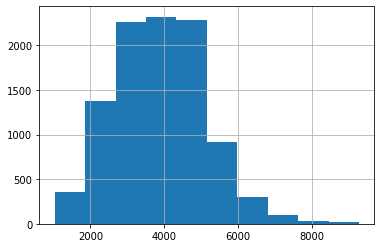

In [439]:
df = df.loc[(df['price_per_m2']>df['price_per_m2'].quantile(.001))&(df['price_per_m2']<df['price_per_m2'].quantile(.999))] 
df['price_per_m2'].hist()

In [440]:
df.drop('price_per_m2', axis=1, inplace=True)

#### KitchenSquare

In [441]:
df.loc[df['KitchenSquare']>100]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1064,62,1,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,629,1,NaN,0,0,108337.484207,1,1,0,47.100719
2969,62,3,114.734473,112.589083,112.0,3,3.0,2015,0.072158,629,1,NaN,0,0,315245.521059,1,1,0,38.244824
4651,58,3,116.405693,113.109653,112.0,3,3.0,2016,0.437885,5735,3,1084.0,0,5,296165.936689,1,1,1,38.801898
8584,81,1,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,5285,0,645.0,6,6,105539.556275,1,1,1,32.276663
9895,27,3,125.806981,123.430072,123.0,5,10.0,2015,0.017647,469,0,NaN,0,0,234194.837047,1,1,1,41.143357


In [442]:
df.loc[df['KitchenSquare']>1000, 'KitchenSquare'] = round(df['KitchenSquare']/100)
df.loc[df['KitchenSquare']>150, 'KitchenSquare'] = round(df['KitchenSquare']/10)

In [443]:
test.loc[test['KitchenSquare']>100]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1777,62,3,112.247841,112.114019,112.0,3,3.0,2017,0.072158,629,1,NaN,0,0,1,1,0,37.371340
1964,11,2,42.795304,24.223770,620.0,11,14.0,1972,0.038693,6533,1,1015.0,2,5,1,1,1,21.397652


In [444]:
test.loc[1964, 'KitchenSquare'] = test.loc[1964, 'KitchenSquare']/100

In [445]:
df['KitchenSquare_0'] = round(df['Square'] - df['LifeSquare'])
df.loc[(df['KitchenSquare_0']<0), 'KitchenSquare_0'] = 0
df.loc[(df['KitchenSquare']==0)&(df['KitchenSquare_0'].notnull()), 'KitchenSquare'] = df['KitchenSquare_0']
df.drop('KitchenSquare_0', axis=1, inplace=True)

In [446]:
test['KitchenSquare_0'] = round(test['Square'] - test['LifeSquare'])
test.loc[(test['KitchenSquare_0']<0), 'KitchenSquare_0'] = 0
test.loc[(test['KitchenSquare']==0)&(test['KitchenSquare_0'].notnull()), 'KitchenSquare'] = test['KitchenSquare_0']
test.drop('KitchenSquare_0', axis=1, inplace=True)

In [447]:
len(df.loc[df['Square']+1<df['LifeSquare']+df['KitchenSquare']])

2468

In [448]:
len(test.loc[test['Square']+1<test['LifeSquare']+test['KitchenSquare']])

1248

In [449]:
sq_minus=(df['Square'] - df['LifeSquare'] - df['KitchenSquare']).mean()

In [450]:
ks_m = round(df['KitchenSquare'].mean())
ks_m

6

Сделаем такое преобразование для этих квартир: поделим условно пополам, между колличеством комнат и кухни

In [451]:
df.loc[df['KitchenSquare']==0,'KitchenSquare'] = ks_m

In [452]:
test.loc[test['KitchenSquare']==0,'KitchenSquare'] = ks_m

In [453]:
df.loc[df['Square']+1<df['LifeSquare']+df['KitchenSquare'], ['KitchenSquare', 'LifeSquare']] = [ks_m, df.loc[df['Square']+1<df['LifeSquare']+df['KitchenSquare'], 'Square'] -  ks_m - 1]


C:\Users\druzh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [454]:
test.loc[test['Square']+1<test['LifeSquare']+test['KitchenSquare'], ['KitchenSquare', 'LifeSquare']] = [ks_m, test.loc[test['Square']+1<test['LifeSquare']+test['KitchenSquare'], 'Square'] -  ks_m - 1]


C:\Users\druzh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [455]:
df['KitchenSquare'] = df['KitchenSquare'].astype(int)
test['KitchenSquare'] = test['KitchenSquare'].astype(int)

#### Floor и HouseFloor. Конструирование признаков последнего и первого этажа

In [456]:
df['HouseFloor'] = df.HouseFloor.astype(int)
df['Floor_0'] = df['Floor']
df.loc[(df['HouseFloor']<df['Floor_0']), 'Floor'] = df.loc[(df['HouseFloor']<df['Floor']), 'HouseFloor'] 
df.loc[(df['HouseFloor']<df['Floor_0']), 'HouseFloor'] = df.loc[(df['HouseFloor']<df['Floor_0']), 'Floor_0']
df.drop('Floor_0', axis=1, inplace=True)

In [457]:
test['HouseFloor'] = test.HouseFloor.astype(int)
test['Floor_0'] = test['Floor']
test.loc[(test['HouseFloor']<test['Floor_0']), 'Floor'] = test.loc[(test['HouseFloor']<test['Floor']), 'HouseFloor'] 
test.loc[(test['HouseFloor']<test['Floor_0']), 'HouseFloor'] = test.loc[(test['HouseFloor']<test['Floor_0']), 'Floor_0']
test.drop('Floor_0', axis=1, inplace=True)

Мы знаем, что самый высокий дом в США 96 этажей

In [458]:
df.loc[df['HouseFloor']>96]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
6131,5,1,51.944587,48.709601,1,6,99,1977,0.150818,3433,4,2643.0,4,5,296127.115515,1,1,1,51.944587
8599,74,2,74.579809,67.579809,6,5,99,1977,0.075779,1437,3,NaN,0,2,243329.912579,1,1,1,35.873935
8854,30,2,66.811789,65.773749,1,8,117,1977,0.000078,6398,141,1046.0,3,23,207248.370520,1,1,1,32.886874


In [459]:
def mydel(S):
    S= str(S)
    for i in range(len(S)):
        new =S[:i]+S[i+1:]
        print('new', new)
        print(S[:i], 'i+1 = ', S[i+1:])
    return int(new)
print(mydel(131))

new 31
 i+1 =  31
new 11
1 i+1 =  1
new 13
13 i+1 =  
13


In [460]:
def mydel(S):
    S= str(S)
    for i in range(len(S)):
        new =S[:i]+S[i+1:]
    return int(new)
print(df.loc[df['HouseFloor']>96, 'HouseFloor'].apply(mydel))
df.loc[df['HouseFloor']>96, 'HouseFloor'] = df.loc[df['HouseFloor']>96, 'HouseFloor'].apply(mydel)


6131     9
8599     9
8854    11
Name: HouseFloor, dtype: int64


In [461]:
test.loc[test['HouseFloor']>96]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
651,27,3,47.722835,40.722835,6,18,99,1977,0.072158,629,1,NaN,0,0,1,1,0,15.907612


In [462]:
test.loc[651, ['Floor', 'HouseFloor']] = [9,18]

In [463]:
df['Last_floor'] = 0
df['Grand_floor'] = 0
df.loc[df['HouseFloor']==df['Floor'], 'Last_floor'] = 1
df.loc[df['Floor']==0, 'Grand_floor'] = 1

In [464]:
test['Last_floor'] = 0
test['Grand_floor'] = 0
test.loc[test['HouseFloor']==test['Floor'], 'Last_floor'] = 1
test.loc[test['Floor']==0, 'Grand_floor'] = 1

#### Healthcare_1
Видели небольшую корреляцию признака с DistrictId, используем это, чтобы заполнить пропуски.

In [465]:
data_pivot = df.pivot_table(index='DistrictId', values ='Healthcare_1',  aggfunc='mean')
print(data_pivot)
healthcare_1_m = df['Healthcare_1'].mean()
print(healthcare_1_m)
data_pivot = data_pivot.reset_index()
print(data_pivot)

            Healthcare_1
DistrictId              
0            2073.583333
1             228.771930
2            1435.254237
3             651.728395
4            2082.909091
...                  ...
196          4702.000000
199          1815.000000
202          4702.000000
207          1815.000000
209          2729.000000

[170 rows x 1 columns]
1140.38361985706
     DistrictId  Healthcare_1
0             0   2073.583333
1             1    228.771930
2             2   1435.254237
3             3    651.728395
4             4   2082.909091
..          ...           ...
165         196   4702.000000
166         199   1815.000000
167         202   4702.000000
168         207   1815.000000
169         209   2729.000000

[170 rows x 2 columns]


In [466]:
b = data_pivot['DistrictId'].unique()
b

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  13,  14,
        16,  17,  19,  20,  21,  22,  23,  24,  26,  28,  29,  30,  31,
        32,  33,  37,  38,  39,  40,  41,  43,  44,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  66,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  84,  85,  86,  87,  89,  90,  91,  93,  95,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 152, 153, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169,
       170, 171, 172, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 188, 189, 190, 192, 193, 194, 195, 196, 199, 202, 207,
       209], dtype=int64)

In [467]:
for d in df['DistrictId'].unique():
    if d not in b:
        data_pivot = data_pivot.append({'DistrictId': d,'Healthcare_1':healthcare_1_m}, ignore_index=True )     
    else:
        data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'] = (data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'] + healthcare_1_m)/2
len(data_pivot)

<ipython-input-467-f1a5d50a3d76>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_pivot = data_pivot.append({'DistrictId': d,'Healthcare_1':healthcare_1_m}, ignore_index=True )
<ipython-input-467-f1a5d50a3d76>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_pivot = data_pivot.append({'DistrictId': d,'Healthcare_1':healthcare_1_m}, ignore_index=True )
<ipython-input-467-f1a5d50a3d76>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_pivot = data_pivot.append({'DistrictId': d,'Healthcare_1':healthcare_1_m}, ignore_index=True )
<ipython-input-467-f1a5d50a3d76>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_pivot = dat

<ipython-input-467-f1a5d50a3d76>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_pivot = data_pivot.append({'DistrictId': d,'Healthcare_1':healthcare_1_m}, ignore_index=True )


205

In [468]:
for d in df['DistrictId'].unique():
    dm = data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'].mean()
    df.loc[(df['Healthcare_1'].isnull())&(df['DistrictId'] == d), 'Healthcare_1'] = dm

In [469]:
for d in df['DistrictId'].unique():
    dm = data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'].mean()
    test.loc[(test['Healthcare_1'].isnull())&(test['DistrictId'] == d), 'Healthcare_1'] = dm

In [470]:
df_test = df.append(test, ignore_index=True)
df_test.head(5)

<ipython-input-470-34429b778380>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df.append(test, ignore_index=True)


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor
0,35,2,47.981561,29.442751,6,7,9,1969,0.089040,7976,5,1140.38362,0,11,184966.930730,1,1,1,23.990781,0,0
1,41,3,65.683640,40.049543,8,7,9,1978,0.000070,10309,1,240.00000,1,16,300009.450063,1,1,1,21.894547,0,0
2,53,2,44.947953,29.197612,16,8,12,1968,0.049637,7759,0,229.00000,1,3,220925.908524,1,1,1,22.473976,0,0
3,58,2,53.352981,46.352981,6,8,17,1977,0.437885,5735,3,1084.00000,0,5,175616.227217,1,1,1,26.676491,0,0
4,99,1,39.649192,23.776169,7,11,12,1976,0.012339,5776,1,2078.00000,2,4,150226.531644,1,1,1,39.649192,0,0


#### Конструирование признака district_size

In [471]:
all_data = pd.concat((df, df_test), sort=False).reset_index(drop=True)
print(f'all_data size is : {all_data.shape}')
district_size = all_data['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})




# district_size = df_test['DistrictId'].value_counts().reset_index()\
#                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df = df.merge(district_size, on='DistrictId', how='left')
test = test.merge(district_size, on='DistrictId', how='left')

df.head(5)

all_data size is : (24910, 21)


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor,DistrictSize
0,35,2,47.981561,29.442751,6,7,9,1969,0.089040,7976,5,1140.38362,0,11,184966.930730,1,1,1,23.990781,0,0,58
1,41,3,65.683640,40.049543,8,7,9,1978,0.000070,10309,1,240.00000,1,16,300009.450063,1,1,1,21.894547,0,0,218
2,53,2,44.947953,29.197612,16,8,12,1968,0.049637,7759,0,229.00000,1,3,220925.908524,1,1,1,22.473976,0,0,439
3,58,2,53.352981,46.352981,6,8,17,1977,0.437885,5735,3,1084.00000,0,5,175616.227217,1,1,1,26.676491,0,0,449
4,99,1,39.649192,23.776169,7,11,12,1976,0.012339,5776,1,2078.00000,2,4,150226.531644,1,1,1,39.649192,0,0,236


#### Конструирование признака Distrikt_D

In [472]:
min_max = MinMaxScaler()
mask = ['Ecology_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1']
min_max.fit(df_test[mask])
df_test[mask] = min_max.transform(df_test[mask])

df_test['Distrikt_D'] = (df_test['Ecology_1']+df_test['Social_2']+df_test['Social_3']+df_test['Healthcare_1']+df_test['Helthcare_2']+df_test['Shops_1'])/len(mask)
dis_d = df_test.groupby('DistrictId').mean().reset_index()[['DistrictId', 'Distrikt_D' ]]

df = df.merge(dis_d, on='DistrictId', how='left')
test = test.merge(dis_d, on='DistrictId', how='left')

## Распределение цены

C:\Users\druzh\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


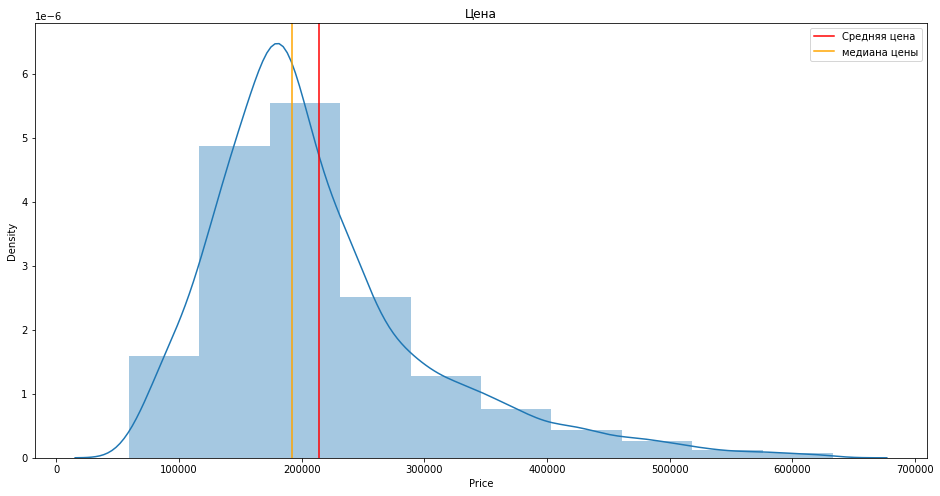

In [473]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins = 10)

plt.axvline(df['Price'].mean(), label='Средняя цена',  color = 'red')
plt.axvline(df['Price'].median(), label='медиана цены',  color = 'orange')


plt.title('Цена')
plt.legend()
plt.show()

## Разделение на train, valid

In [474]:
train, valid = train_test_split(df, test_size=0.25, random_state = 12345)

## Конструирование признаков на train

In [475]:
train['price_per_m2'] = train['Price'] / train['Square'] 
m2 = train.groupby('DistrictId').mean().reset_index()[['DistrictId','price_per_m2']]
m2

,DistrictId,price_per_m2
0,0,3677.423916
1,1,3205.830286
2,2,4568.387660
3,3,3718.917131
4,4,5167.711292
...,...,...
198,200,5360.318269
199,201,8397.602044
200,202,3040.402573
201,207,5550.678339


In [476]:
valid['price_per_m2'] = valid['Price'] / valid['Square'] 

In [477]:
valid

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor,DistrictSize,Distrikt_D,price_per_m2
6148,99,3,62.683364,45.367528,6,1,9,1973,0.012339,5776,1,2078.00000,2,4,93834.252928,1,1,1,20.894455,0,0,236,0.246671,1496.956244
1237,61,2,47.616702,32.756199,6,12,13,1979,0.300323,10311,6,610.19181,1,9,233805.848751,1,1,1,23.808351,0,0,298,0.295067,4910.164662
8341,121,1,33.007566,16.212633,7,2,12,1974,0.212515,3293,16,628.00000,3,7,187037.576138,1,1,1,33.007566,0,0,61,0.260069,5666.506094
9380,75,1,34.539033,21.822347,6,4,5,1961,0.122090,6566,7,1894.00000,4,0,140036.198060,1,1,1,34.539033,0,0,166,0.265787,4054.433079
9826,27,1,37.551366,30.551366,6,1,11,1977,0.211401,1892,0,1140.38362,0,1,112877.827651,1,1,1,37.551366,0,0,2079,0.085014,3005.957937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,53,2,54.660894,30.114409,8,11,12,1985,0.049637,7759,0,229.00000,1,3,247980.275234,1,1,1,27.330447,0,0,439,0.189021,4536.703612
4783,74,1,39.526308,22.613150,7,11,14,2006,0.371149,7065,1,750.00000,2,5,175002.665085,1,1,1,39.526308,0,0,289,0.136765,4427.498442
6282,53,1,38.079975,31.079975,6,1,5,1977,0.049637,7759,0,229.00000,1,3,239736.058719,1,1,1,38.079975,0,0,439,0.189021,6295.593847
7826,23,1,55.817841,21.256710,11,4,4,2018,0.014073,475,0,570.19181,0,0,107825.997095,1,1,1,55.817841,1,0,1390,0.048769,1931.747890


In [478]:
# valid['price_per_m2']

In [479]:
train.drop('price_per_m2', axis=1, inplace=True)
valid.drop('price_per_m2', axis=1, inplace=True)

In [480]:
valid = valid.merge(m2, on='DistrictId', how='left')
train = train.merge(m2, on='DistrictId', how='left')
price_per_m2_m = train['price_per_m2'].mean()
valid.loc[valid['price_per_m2'].isnull()] = price_per_m2_m

In [481]:
train['Pprice'] = train['price_per_m2']*train['Square']

valid['Pprice'] = valid['price_per_m2']*valid['Square']

In [482]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor,DistrictSize,Distrikt_D,price_per_m2,Pprice
0,101,2,46.606298,29.882507,5,4,5,1960,0.225825,6558,7,1548.000000,3,2,195841.345382,0,1,1,23.303149,0,0,240,0.266632,4039.433531,188263.044090
1,1,1,48.060539,41.060539,6,1,1,1977,0.007122,264,0,684.577775,0,1,124591.333737,1,1,1,48.060539,1,0,1646,0.043222,3205.830286,154073.933023
2,121,2,45.250953,23.171747,6,10,14,1977,0.212515,3293,16,628.000000,3,7,89659.187785,1,1,1,22.625477,0,0,61,0.260069,4748.496469,214873.991883
3,47,3,82.666612,45.938245,12,8,14,2009,0.197368,2423,1,32.000000,0,1,316106.229882,1,1,1,27.555537,0,0,243,0.206132,4126.059516,341087.360782
4,27,3,84.274055,50.505379,8,7,9,1997,0.041116,14892,4,1140.383620,1,4,291518.545216,1,1,1,28.091352,0,0,2079,0.085014,2744.956537,231328.618903


In [483]:
mask = (list(train.columns))
mask.remove('Price')
mask.remove('DistrictId')

In [484]:
y_train = train['Price']
X_train = train[mask]
y_valid = valid['Price']
X_valid = valid[mask]


In [485]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train[mask] = scaler.transform(X_train)
X_valid[mask] = scaler.transform(X_valid)

<ipython-input-485-5665fc7283b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[mask] = scaler.transform(X_train)
<ipython-input-485-5665fc7283b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[mask] = scaler.transform(X_valid)


## Обучение модели

In [486]:
GBR = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5).fit(X_train, y_train)

In [487]:
y_train_preds = GBR.predict(X_train)
y_valid_preds = GBR.predict(X_valid)

print("Train R2:\t" + str(round(r2(y_train, y_train_preds), 3)))
print("Test R2:\t" + str(round(r2(y_valid_preds, y_valid), 3)))


Train R2:	0.915
Test R2:	0.711


In [488]:
feature_importances = pd.DataFrame(zip(X_train.columns, GBR.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
22,Pprice,0.710130
6,HouseYear,0.032513
16,Square_Room,0.025426
5,HouseFloor,0.024535
21,price_per_m2,0.021888
2,LifeSquare,0.021864
1,Square,0.021240
10,Healthcare_1,0.019611
3,KitchenSquare,0.019415
8,Social_2,0.016239


### Предсказание для test

In [489]:
df['price_per_m2'] = df['Price'] / df['Square'] 
m2 = df.groupby('DistrictId').mean().reset_index()[['DistrictId','price_per_m2']]
df.drop('price_per_m2', axis=1, inplace=True)

In [490]:
df = df.merge(m2, on='DistrictId', how='left')
test = test.merge(m2, on='DistrictId', how='left')
test.loc[test['price_per_m2'].isnull()] = price_per_m2_m
test['Pprice'] = test['price_per_m2']*test['Square']
df['Pprice'] = df['price_per_m2']*df['Square']

In [491]:
pd.set_option('display.max_columns', None)
test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor,DistrictSize,Distrikt_D,price_per_m2,Pprice
0,58.0,2.0,49.882643,33.432782,6.0,6.0,14.0,1972.0,0.310199,2748.0,1.0,1069.751185,0.0,0.0,1.0,1.0,1.0,24.941322,0.0,0.0,449.0,0.217670,3017.257551,150508.782421
1,74.0,2.0,69.263183,62.263183,6.0,1.0,6.0,1977.0,0.075779,1437.0,3.0,986.320842,0.0,2.0,1.0,1.0,1.0,34.631592,0.0,0.0,289.0,0.136765,3344.694536,231664.191309
2,190.0,1.0,15.948246,8.948246,6.0,2.0,5.0,1909.0,0.000000,7538.0,87.0,4702.000000,5.0,5.0,1.0,1.0,1.0,13.597819,0.0,0.0,14.0,0.504511,7351.281724,117240.052265
3,47.0,2.0,73.046609,51.940842,9.0,22.0,22.0,2007.0,0.101872,4583.0,3.0,710.130585,3.0,3.0,1.0,1.0,1.0,36.523305,1.0,0.0,243.0,0.206132,4116.345095,300685.051582
4,27.0,1.0,47.527111,43.387569,1.0,17.0,17.0,2017.0,0.072158,629.0,1.0,1140.383620,0.0,0.0,1.0,1.0,0.0,47.527111,1.0,0.0,2079.0,0.085014,2759.334258,131143.184745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11.0,3.0,67.133911,50.809797,6.0,5.0,9.0,1973.0,0.000170,5992.0,0.0,1219.500143,1.0,1.0,1.0,1.0,1.0,22.377970,0.0,0.0,303.0,0.166550,4055.974766,272293.450526
4996,1.0,1.0,40.198472,21.807061,10.0,12.0,17.0,2017.0,0.007122,264.0,0.0,684.577775,0.0,1.0,1.0,1.0,1.0,40.198472,0.0,0.0,1646.0,0.043222,3201.164936,128681.938560
4997,12.0,3.0,77.842178,48.282625,9.0,22.0,23.0,1989.0,0.090799,19083.0,2.0,1140.383620,5.0,15.0,1.0,1.0,1.0,25.947393,0.0,0.0,164.0,0.484810,4101.760521,319289.972334
4998,62.0,2.0,81.305222,74.305222,6.0,0.0,4.0,1977.0,0.072158,629.0,1.0,1720.191810,0.0,0.0,1.0,1.0,0.0,40.652611,0.0,1.0,614.0,0.107816,2780.597906,226077.130006


In [492]:
mask = (list(df.columns))
mask.remove('Price')
mask.remove('DistrictId')

In [493]:
y_train = df['Price']
X_train = df[mask]
X_test = test[mask]

In [494]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train[mask] = scaler.transform(X_train)
X_test[mask] = scaler.transform(X_test)

<ipython-input-494-2d0acf332f71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[mask] = scaler.transform(X_train)
<ipython-input-494-2d0acf332f71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[mask] = scaler.transform(X_test)


In [495]:
GBR = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5).fit(X_train, y_train)

In [496]:
y_train_preds = GBR.predict(X_train)
print("Train R2:\t" + str(round(r2(y_train, y_train_preds), 3)))

Train R2:	0.901


In [497]:
feature_importances = pd.DataFrame(zip(X_train.columns, GBR.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
22,Pprice,0.722973
6,HouseYear,0.030624
16,Square_Room,0.024052
5,HouseFloor,0.022966
21,price_per_m2,0.022056
1,Square,0.021997
2,LifeSquare,0.021005
3,KitchenSquare,0.018359
10,Healthcare_1,0.017733
7,Ecology_1,0.015759


In [498]:
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["price_pred"] = GBR.predict(X_test)

In [499]:
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv(r"C:\Users\druzh\Desktop\data_scientist\price_predictions.csv", index=False)

In [500]:
pred_df = pd.read_csv("C:\\Users\\druzh\\Desktop\\data_scientist\\price_predictions.csv")
pred_df.head(n=5)

,Id,price_pred
0,725,157058.642180
1,15856,210656.701283
2,5480,149418.874113
3,15664,344327.338160
4,14275,136526.815941
